In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-data5m/yelp_data5M.json
/kaggle/input/yelp-data1m/yelp_data1M.json
/kaggle/input/yelp-business-dataset/yelp_business_data.json
/kaggle/input/yelp-data2m/yelp_data2M.json
/kaggle/input/tokenized-arrays/tokenized_arrays.npz
/kaggle/input/yelp-data3m/yelp_data3M.json
/kaggle/input/yelp-data7m/yelp_data7M.json
/kaggle/input/yelp-data6m/yelp_data6M.json
/kaggle/input/yelp-data4m/yelp_data4M.json


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the business data

In [4]:
business = pd.read_json("/kaggle/input/yelp-business-dataset/yelp_business_data.json", lines=True)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


## Reading the Review Data (split in 7 files)

In [5]:
reviews1 = pd.read_json("/kaggle/input/yelp-data1m/yelp_data1M.json", lines=True)
reviews2 = pd.read_json("/kaggle/input/yelp-data2m/yelp_data2M.json", lines=True)
reviews3 = pd.read_json("/kaggle/input/yelp-data3m/yelp_data3M.json", lines=True)
reviews4 = pd.read_json("/kaggle/input/yelp-data4m/yelp_data4M.json", lines=True)
reviews5 = pd.read_json("/kaggle/input/yelp-data5m/yelp_data5M.json", lines=True)
reviews6 = pd.read_json("/kaggle/input/yelp-data6m/yelp_data6M.json", lines=True)
reviews7 = pd.read_json("/kaggle/input/yelp-data7m/yelp_data7M.json", lines=True)

## Concatenating all the reviews together (about 7 million reviews totally)

In [6]:
reviews = pd.concat([reviews1, reviews2, reviews3, reviews4, reviews5, reviews6, reviews7])

In [7]:
reviews.shape

(6990280, 9)

In [8]:
# find the columns with missing value from business and reviews data
cols_with_missing_values = business.columns[business.isna().any()]
print(f"columns with missing values in business data: {cols_with_missing_values}")
cols_with_missing_values = reviews.columns[reviews.isna().any()]
print(f"columns with missing values in reviews data: {cols_with_missing_values}")

columns with missing values in business data: Index(['attributes', 'categories', 'hours'], dtype='object')
columns with missing values in reviews data: Index([], dtype='object')


## Clustering the categories column

In [9]:
# fill in the missing values from the categories column
business['categories'] = business['categories'].fillna('')

In [10]:
def cat2vec(df):
    categories = df['categories'].unique()
    
    # get only categories which are relatd to restaurants
    restaurant_categories = []
    for cat in categories:
      if "Restaurants" in cat:
        restaurant_categories.append(cat)
    
    # vectorize the categories for K means clustering
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(restaurant_categories)
    return X
    

### Using elbow method to find optimal K (number of clusters)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


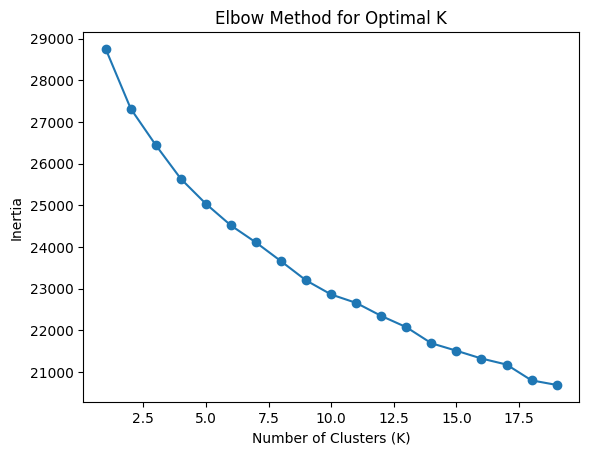

In [11]:
X = cat2vec(business)
inertias = []
K_range = range(1, 20)
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

### Using silhouette score analysis to find optimal K (number of clusters)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


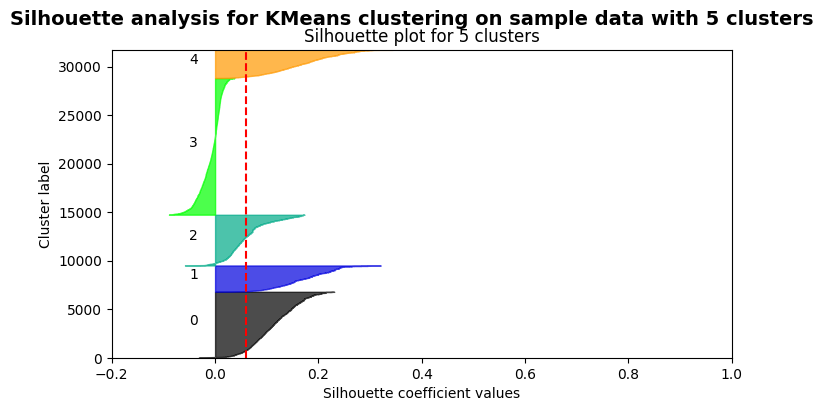

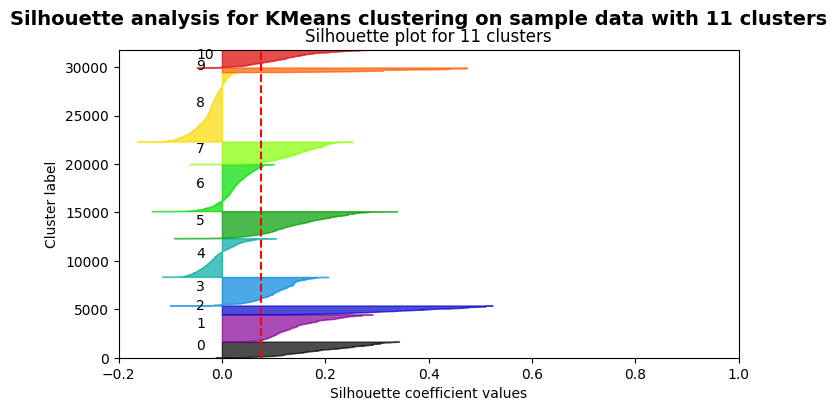

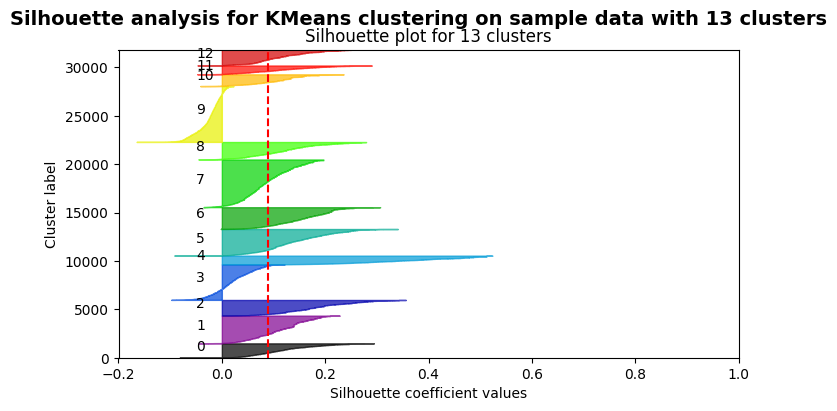

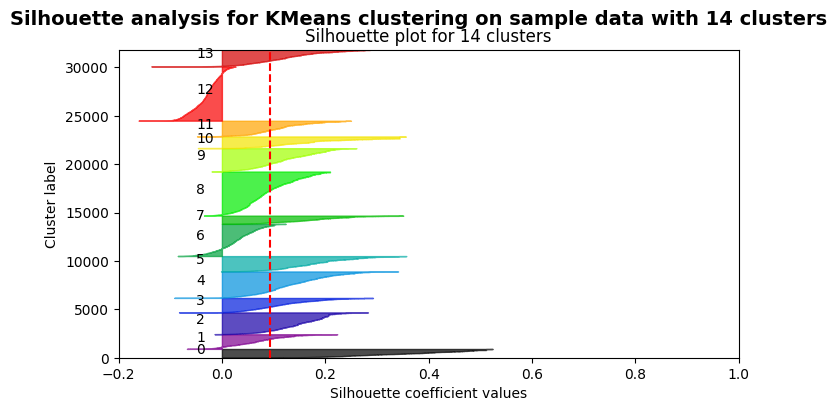

In [12]:
silhouette_scores = []
range_n_clusters = [5, 11, 13, 14]  # Define the range of cluster numbers
X = cat2vec(business)

for n_clusters in range_n_clusters:
    # Initialize KMeans
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)  # X is your data

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Create a subplot for each cluster number
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    ax.set_title("Silhouette plot for {} clusters".format(n_clusters))
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with {} clusters".format(n_clusters)), fontsize=14, fontweight='bold')

# Display the silhouette scores for each K
plt.show()



### Running K means with chosen optimal K (number of clusters)

In [17]:
# Choose the number of clusters (K)
K = 13 # You can change this based on your analysis

# Create the K-means model
kmeans = KMeans(n_clusters=K, random_state=42)

# Fit the model to your TF-IDF data
kmeans.fit(X)

# Get cluster labels for each category
cluster_labels = kmeans.labels_

In [18]:
restaurant_categories = []
for cat in business['categories']:
  if "Restaurants" in cat:
    restaurant_categories.append(cat)

# Create a dictionary to store categories in each cluster
clusters = {i: [] for i in range(K)}

# Assign each category to a cluster
for i, label in enumerate(cluster_labels):
    clusters[label].append(restaurant_categories[i])

# Print the categories in each cluster
for cluster, category_list in clusters.items():
    print(f"Cluster {cluster + 1}:")
    print(f"cluster size: {len(category_list)}")
    for category in category_list[:10]:
        print(category)

    print()

Cluster 1:
cluster size: 1475
Sports Bars, American (New), American (Traditional), Nightlife, Bars, Restaurants
Restaurants, Chinese
Fast Food, Restaurants, Food, Burgers, Coffee & Tea
Restaurants, American (New), Breakfast & Brunch, Burgers
Korean, American (Traditional), Sandwiches, Cheesesteaks, Restaurants, Coffee & Tea, Breakfast & Brunch, Food
Restaurants, Bakeries, Cafes, Bagels, Food, Soup, Salad, Sandwiches, Breakfast & Brunch
Restaurants, Indian
American (New), Restaurants
Restaurants, American (Traditional), Bars, Nightlife, Pubs, Sandwiches
Donuts, Food, Coffee & Tea, Restaurants

Cluster 2:
cluster size: 2853
American (Traditional), Restaurants, Diners, Breakfast & Brunch
Restaurants, Sandwiches, Pizza, Chicken Wings
Restaurants, Mexican
Latin American, Honduran, Restaurants
American (New), Barbeque, Restaurants, Burgers, Sandwiches, Salad
Indian, Restaurants
Restaurants, Caterers, Barbeque, American (Traditional), Event Planning & Services
Italian, Spanish, Restaurants, F

## Filtering the businesses based on categories column

In [ ]:
# filter all the business which contain the word "Bars" in the categories column
filtered_business_bars = business[business['categories'].str.contains('Bars', case=False)]

# remove the business which belong to Juice Bars category
filtered_business_bars = filtered_business_bars[~filtered_business_bars['categories'].str.contains('Juice', case=False)]

In [ ]:
# Check how many businesses are there after filtering
unique_count = filtered_business_bars['business_id'].nunique()
unique_count

## Sort the filtered businesses based on review_count coulmn to get top 10K businesses with highest review count

In [ ]:
# Sort reviews by review_count column
filtered_business_bars = filtered_business_bars.sort_values(by='review_count', ascending=False)

In [ ]:
filtered_business_bars.head()

In [ ]:
# select 10000 businesses from the top
bars_10K = filtered_business_bars.iloc[:10000]

In [ ]:
# check how many reviews we have for these 10000 businesses
reviews_count = bars_10K['review_count'].sum()
reviews_count

#1,763,731

## Merging the filtered businesses with reviews data

In [ ]:
# merge the filtered business with reviews data to get the final dataframe of interest
bars_10k_reviews = pd.merge(bars_10K, reviews, on='business_id', how='left')
bars_10k_reviews.shape

In [ ]:
bars_10k_reviews.head()

## Preprocess the text from the review column

In [ ]:
def preprocess_text(text):
  # Remove punctuation and convert to lowercase
  text = text.translate(str.maketrans('', '', string.punctuation)).lower()
  # Tokenize the text
  tokens = word_tokenize(text)
  # Remove stopwords and lemmatize
  tokens = [token for token in tokens if token not in stop_words]
  return (' '.join(tokens))

In [ ]:
bars_10k_reviews['clean_text'] = bars_10k_reviews['text'].apply(preprocess_text)

In [ ]:
bars_10k_reviews.head()

## Get the review length for all the reviews based on number of words

In [ ]:
bars_10k_reviews['review_length'] = bars_10k_reviews['clean_text'].apply(lambda x: len(x.split()))

In [ ]:
bars_10k_reviews.head()

## Get the percentile boundary for 25th and 75th percentile

In [ ]:
review_lengths = list(bars_10k_reviews['review_length'])
print(f"Number of reviews: {len(review_lengths)}")
# Calculate the 75th and 25th percentiles
percentile_75 = np.percentile(review_lengths, 75)
percentile_25 = np.percentile(review_lengths, 25)
print("75th Percentile:", percentile_75)
print("25th Percentile:", percentile_25)


## Discard all the reviews where the review length is less than 22 words (bottom 25 percentile is eleminated)

In [ ]:
bars_10k_reviews = bars_10k_reviews[bars_10k_reviews['review_length']>22.0]

In [ ]:
bars_10k_reviews.shape

In [ ]:
bars_10k_reviews['business_id'].nunique()

## Alternate apporach of filtering the categories

In [ ]:
def cleanedCats(categories_list):

    cleaned_cats = list()
    for cat_str in categories_list:
        cat_list = cat_str.split(",")
        for cat in cat_list:
            cat = cat.strip()
            cleaned_cats.append(cat)
    
    value_counts = pd.Series(cleaned_cats).value_counts()
    for value, count in value_counts.items():
        print(f"{value}: {count}")
        
    return value_counts

In [ ]:
cleanedCats(restaurant_categories)

In [ ]:
american_food = []
for cat in restaurant_categories:
    if "American (Traditional)" in cat or "American (New)" in cat:
        american_food.append(cat)

In [ ]:
cleanedCats(american_food)

In [ ]:
categories_to_filter = ['American (Traditional)', 'American (New)', 
                        'Chicken Wings']

In [ ]:
def contains_desired_category(categories):
    category_list = [category.strip() for category in categories.split(',')]
    for category in category_list:
        if category in categories_to_filter:
            return True
    return False

In [ ]:
filtered_df = business[business['categories'].apply(contains_desired_category)]

# Display the filtered DataFrame
filtered_df.shape

In [ ]:
print(f"Number of businesses: {filtered_df['business_id'].nunique()}")
print(f"Number of reviews: {filtered_df['review_count'].sum()}")

In [ ]:
value_counts = cleanedCats(filtered_df['categories'].unique())

In [ ]:
unwanted_categories = []
for value, count in value_counts.items():
    if count < 190:
        unwanted_categories.append(value)

In [ ]:
def has_unwanted_category(categories):
    category_list = categories.split(', ')
    return any(category in category_list for category in unwanted_categories)

In [ ]:
filtered_df2 = filtered_df[~filtered_df['categories'].apply(lambda x: has_unwanted_category(x))]

In [ ]:
c = filtered_df2['categories'].unique()
cv = cleanedCats(c)

In [ ]:
print(f"Number of businesses: {filtered_df2['business_id'].nunique()}")
print(f"Number of reviews: {filtered_df2['review_count'].sum()}")

In [ ]:
filtered_df2.head()

In [ ]:
business_10k_reviews = pd.merge(filtered_df2, reviews, on='business_id', how='inner')
business_10k_reviews.shape

In [ ]:
business_10k_reviews.head()

## Saving the filtered dataset

In [ ]:
business_10k_reviews.to_csv('/kaggle/working/final_dataset.csv', index=False)

In [ ]:
import os 
from IPython.display import FileLink 
os.chdir(r'/kaggle/working')
FileLink(r'final_dataset.csv')

## Extracting 10,000 reviews via stratified sampling

In [ ]:
def stratified_sampling(reviews):

    sample_reviews = pd.DataFrame(columns=list(business_10k_reviews.columns))
    total_sample_size = 10000
    proportions = reviews['business_id'].value_counts() / len(reviews)
    num_reviews_to_sample = (proportions * total_sample_size).round().astype(int)

    for restaurant_id, num_to_sample in num_reviews_to_sample.items():
        restaurant_reviews = reviews[reviews['business_id'] == restaurant_id]
        selected_reviews = restaurant_reviews.sample(n=num_to_sample, random_state=42)
        sample_reviews = pd.concat([sample_reviews, selected_reviews], ignore_index=True)

    return sample_reviews


In [ ]:
sampled_reviews = stratified_sampling(business_10k_reviews)

In [ ]:
sampled_reviews.shape

In [ ]:
sampled_reviews.head()

In [ ]:
sampled_reviews.tail()

### Saving the sampled reviews dataset

In [ ]:
sampled_reviews.to_csv('/kaggle/working/sample_reviews.csv', index=False)

In [ ]:
import os 
os.chdir(r'/kaggle/working')

In [ ]:
from IPython.display import FileLink 
FileLink(r'sample_reviews.csv')